In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import beta
import scipy.special

#from sklearn.preprocessing import normalize

%matplotlib inline

## Generate NegBin data

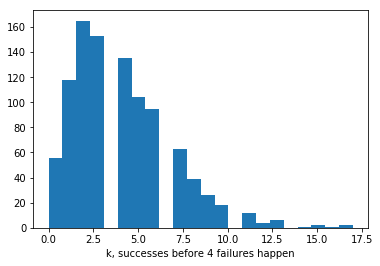

In [42]:
N = 1000 # size of toy data
alp = 2. 
bet = 2.
true_mu = .5


# the NB is defined for a fixed number of failures, r. 
# It describes the distribution of successes until r failures have occured, or the other way around. 
# thus, the number of trials is implicit 
n_failures = 4
true_mean = n_failures * true_mu / (1 - true_mu)

X_o = np.random.negative_binomial(n=n_failures, p=true_mu, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))

plt.hist(X_o, bins='auto');
plt.xlabel('k, successes before {} failures happen'.format(n_failures));

## Derive posterior over $\mu$ with a Beta prior

The likelihood for observing $x_i$ successes with a success probability of $\mu$ before $M$ failures occurred when drawing $N$ times is given by the negbin pdf 

$$
p(x| \mu) = \prod_{i=1}^N {{x_i + M - 1}\choose{x_i}} (1 - \mu)^{M}\mu^{x_i}. 
$$

The conjugtae prior for $\mu$ is the Beta distribution 

$$
p(\mu) = Beta(\alpha, \beta) = \frac{\mu^{\alpha - 1} (1 - \mu)^{\beta - 1}}{B(\alpha, \beta)}
$$

The marginal likelihood is given by 

$$
E = \int p(x | \mu) p(\mu) d\mu = \frac{B(\alpha + \sum x_i, \beta + NM)}{B(\alpha, \beta)}\prod_{i=1}^N {{x_i + M - 1}\choose{x_i}}
$$

Thus, the posterior is given by 

$$
p(\mu | x) = \frac{p(x| \mu)p(\mu) }{\int p(x | \mu) p(\mu) d\mu} = \frac{\prod_{i=1}^N {{x_i + M - 1}\choose{x_i}} (1 - \mu)^{M}\mu^{x_i}\frac{\mu^{\alpha - 1} (1 - \mu)^{\beta - 1}}{B(\alpha, \beta)}}{\frac{B(\alpha + \sum x_i, \beta + NM)}{B(\alpha, \beta)}\prod_{i=1}^N {{x_i + M - 1}\choose{x_i}}} = \frac{(1-\mu)^{NM + \beta -1}\mu^{\sum x_i + \alpha - 1}}{B(\alpha + \sum x_i, \beta + NM)} = Beta(\alpha + \sum x_i, \beta + NM)
$$

In [43]:
# hard coded function for calculating the posterior and evidence separately. 
# The result is somehow not normalized so there might be a bug or varying definitions of the negbin in 
# numpy.random or scipy.stats 

def posterior(mu, ks, alpha, beta, log=True): 
    N = ks.size
    M = n_failures
    s1 = np.sum(scipy.special.binom(ks + M - 1, ks))
    s2 = (N*M + beta - 1) * np.log(1 - mu)
    s3 = (np.sum(ks) + alpha - 1)*np.log(mu)
    s4 = - scipy.special.betaln(alpha, beta)
    result = s1 + s2 + s3 + s4
    return result if log else np.exp(result)

def log_nbin_evidence(x, alpha, beta): 
    N = x.size
    M = n_failures
    s1 = scipy.special.betaln(alpha + x.sum(), beta + N * M)
    s2 = -scipy.special.betaln(alpha, beta)
    s3 = np.sum(np.log(scipy.special.binom(x + M - 1, x)))
    return s1 + s2 + s3

## Learn MDN to predict the posterior over $\mu$ 

The MDN has to approximate a Beta distribution. Thus, the output should be the shape and scale parameters of the Beta distribution. The sufficient statistics for the negative binomial is just $x$ and for many samples just the sum $\sum x_i$. 

In [44]:
# The cost function of the MDN needs to evaluate the beta distribution written in pytorch terms: 

def log_gamma(xx):
    gamma_coeff = [
        76.18009172947146,
        -86.50532032941677,
        24.01409824083091,
        -1.231739572450155,
        0.1208650973866179e-2,
        -0.5395239384953e-5,
    ]
    magic1 = 1.000000000190015
    magic2 = 2.5066282746310005
    x = xx - 1.0
    t = x + 5.5
    t = t - (x + 0.5) * torch.log(t)
    ser = Variable(torch.ones(x.size()) * magic1)
    for c in gamma_coeff:
        x = x + 1.0
        ser = ser + torch.pow(x / c, -1)
    return torch.log(ser * magic2) - t

def log_betafun(a, b): 
    # beta function is defined in terms of gamma as: B(a, b) = gamma(a)gamma(b)/gamma(a + b)
    return log_gamma(a) + log_gamma(b) - log_gamma(a + b)

def beta_pdf(mu, a, b, log=True): 
    one = Variable(torch.ones(mu.size()).type_as(a.data))
    result = (a - 1) * torch.log(mu) + (b - 1) * torch.log(1 - mu) - log_betafun(a, b)
    return result if log else torch.exp(result)

def generate_dataset(N, m, alpha, beta, normalize=False):
    # N data sets 
    # each with m samples 
    
    X = []
    thetas = []
    
    for i in range(N): 
        # sample from the prior 
        mu = np.random.beta(alpha, beta)

        # generate samples
        
        x = np.random.negative_binomial(n=n_failures, p=mu, size=m)
        
        # as data we append the summary stats
        X.append([np.mean(x)])
        thetas.append([mu])
    
    X = np.array(X)
    xmean = X.mean(axis=0)
    xstd = X.std(axis=0)
    if normalize: 
        X = (X - xmean) / xstd
    th = np.array(thetas)
    
    return X, th, xmean, xstd

In [45]:
class MDN_phi(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN_phi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.alpha_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())
        self.beta_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_alpha = self.alpha_out(act)
        out_beta = self.beta_out(act)
        return (out_alpha, out_beta)

# the loss evaluates model (MoG) with the given data (y) and takes the log loss
def mdn_loss_function(out_shape, out_scale, y):
    result = beta_pdf(y, out_shape, out_scale, log=True)
    result = torch.mean(result)  # mean over batch
    return -result

def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys
        
def train(X, Y, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_shape, out_scale) = model(x_var)
            loss = mdn_loss_function(out_shape, out_scale, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))

In [48]:
X, Y, data_mean, data_std = generate_dataset(2000, N, alpha=alp, beta=bet)

In [49]:
model = MDN_phi(ndim_input=1, n_components=1)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

In [50]:
train(X, Y, n_epochs=2000)

[epoch 0050] loss: -1.8394
[epoch 0100] loss: -2.1593
[epoch 0150] loss: -2.2882
[epoch 0200] loss: -2.4106
[epoch 0250] loss: -2.5212
[epoch 0300] loss: -2.5556
[epoch 0350] loss: -2.5639
[epoch 0400] loss: -2.6330
[epoch 0450] loss: -2.6689
[epoch 0500] loss: -2.6377
[epoch 0550] loss: -2.7489
[epoch 0600] loss: -2.7627
[epoch 0650] loss: -2.7457
[epoch 0700] loss: -2.8182
[epoch 0750] loss: -2.7422
[epoch 0800] loss: -2.8297
[epoch 0850] loss: -2.8882
[epoch 0900] loss: -2.9253
[epoch 0950] loss: -2.8634
[epoch 1000] loss: -2.8269
[epoch 1050] loss: -2.9500
[epoch 1100] loss: -2.9272
[epoch 1150] loss: -2.9148
[epoch 1200] loss: -2.9474
[epoch 1250] loss: -2.9312
[epoch 1300] loss: -2.9842
[epoch 1350] loss: -2.9707
[epoch 1400] loss: -2.9565
[epoch 1450] loss: -2.9962
[epoch 1500] loss: -3.0241
[epoch 1550] loss: -2.9944
[epoch 1600] loss: -3.0444
[epoch 1650] loss: -2.9428
[epoch 1700] loss: -3.0154
[epoch 1750] loss: -3.0255
[epoch 1800] loss: -3.0649
[epoch 1850] loss: -2.9771
[

## Calculate the prior and posterior used by the MDN

In [51]:
# now evaluate the model at the observed data 
# normalize data
#stats_o = ((X_o - data_mean) / data_std).astype(float).reshape(1, 1) 
stats_o = (np.mean(X_o)).astype(float).reshape(1, 1) 

X_var = Variable(torch.Tensor(stats_o))

(out_shape, out_scale) = model(X_var)

In [52]:
n_thetas = 1000
thetas = np.linspace(0.01, .99, n_thetas)

# make sure all variabel have dimensions (N, 1)
out_shapes = Variable(torch.Tensor(out_shape.data * torch.ones(thetas.size))).view(n_thetas, 1)
out_scales = Variable(torch.Tensor(out_scale.data * torch.ones(thetas.size))).view(n_thetas, 1)

posterior_pred = beta_pdf(Variable(torch.Tensor(thetas.reshape(n_thetas, 1))), out_shapes, out_scales, log=False).data.numpy()

## Plot the predictive and the analystical posterior over the whole range of mus 

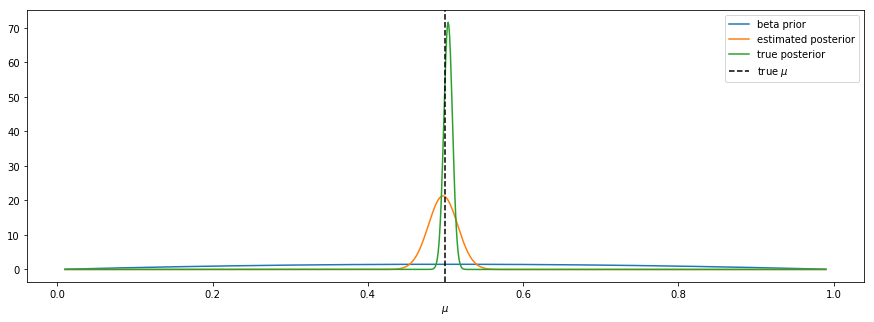

In [53]:
N = X_o.size 
M = n_failures

# analytical posterior 
mus = thetas

prior1 = beta.pdf(mus, alp, bet)

a = alp + X_o.sum()
b = bet + N * M
post_ana = beta.pdf(mus, a, b)

# plotting 
plt.figure(figsize=(15, 5))
plt.plot(mus, prior1, label='beta prior')

plt.plot(mus, posterior_pred, label='estimated posterior')
plt.plot(mus, post_ana, label='true posterior')
plt.axvline(x=true_mu, ls='--', c='k', label=r'true $\mu$')
plt.xlabel(r'$\mu$')
plt.legend(); 

## Plot the corresponding posterior for the NegBin mean

With a change of variables from probability of success $X = \mu$ to the mean of the negative binomial $Y = y$ we can plot the posterior over the mean: 

$$
f_{X}(x) = Beta(x, \alpha + \sum x_i, \beta + NM) \\
Y = u(X) = \frac{M X}{1 - X}, X \in [0, 1) \\
X = v(Y) = \frac{Y}{M + Y}, M + Y > 0
$$

Then with change of variables from $X$ to $Y$ we have 

$$
f_{Y}(y) = f_X(v(y)) \cdot v'(y) = Beta(x, \alpha + \sum x_i, \beta + NM) \cdot \frac{M}{(M + y)^2}
$$

In [54]:
# define new range of interest
ys = M * mus /(1 - mus)

up_to = 600

# true posterior 
postmean_true = post_ana * M / (M + ys)**2
poo = beta.pdf(mus, a, b) * M / (M + ys)**2

# predicted posterior 
postmean_pred = posterior_pred * M / (M + ys)**2

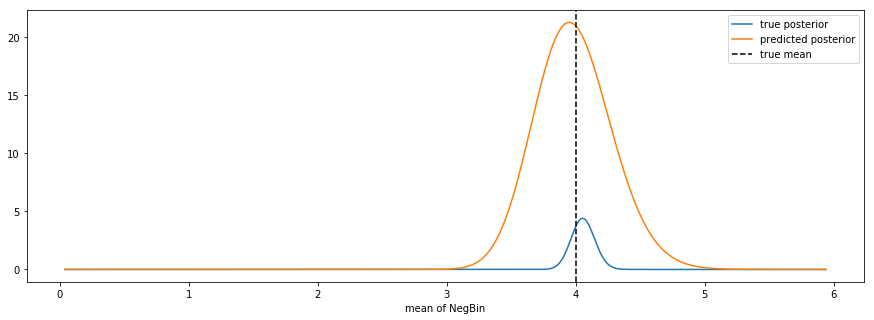

In [55]:
plt.figure(figsize=(15, 5))
plt.plot(ys[:up_to], postmean_true[:up_to], label='true posterior') 
plt.plot(ys[:up_to], posterior_pred[:up_to], label='predicted posterior')

plt.axvline(x=true_mean, ls='--', c='k', label=r'true mean')
plt.xlabel('mean of NegBin')
plt.legend();